In [1]:
from library.webuiapi import WebUIApi, QueuedTaskResult, ControlNetUnit, raw_b64_img
import os
import json
import requests
import time
from PIL import Image
from threading import Thread

In [2]:
instance = WebUIApi(host="127.0.0.1", port=7860)

In [23]:
target_path = r"./example_lora/haibara_dylora_reg2.safetensors"
target_path_2 = r'./example_lora/haibara-compare-autotrain-000006.safetensors'

In [4]:
result_list_container = []
controlnet_path = r"C:\Users\Admin\Pictures\pose.png"
mask_path = r"C:\Users\Admin\Pictures\mask.png"


In [24]:

def open_controlnet_image(path:str):
    control_ref_img = Image.open(path)
    control_ref_img = control_ref_img.convert("RGB")
    return control_ref_img

def open_mask_image(path:str):
    mask_ref_img = Image.open(path)
    mask_ref_img = mask_ref_img.convert("RGB")
    return mask_ref_img

def wrap_upload_loras(apiInstance:WebUIApi, lora_dir:str):
    apiInstance.set_overwrite(True) # set overwrite to True
    lora_name = os.path.basename(lora_dir).split(".")[0]
    apiInstance.upload_lora(lora_dir, "test_by_api") # upload lora model from target_path to server's test_lora dir
    return lora_name


def process_test(apiInstance:WebUIApi, control_ref_path:str, mask_ref_path:str, 
                 lora_name_1:str="haibara_dynamic_lora_reg2",
                 lora_name_2:str="haibara_compare_autotrain",
                 tag_1:str="character name is haibara ai",
                 tag_2:str="character name is haibara ai"):
    control_ref_img = open_controlnet_image(control_ref_path)
    mask_ref_img = open_mask_image(mask_ref_path)
    control_unit = ControlNetUnit(input_image=control_ref_img, module='none', model='control_v11p_sd15_openpose [cab727d4]')
    result_control_latent_couple = apiInstance.txt2img_task(
        prompt = fr""" night, sky, forest, detailed, street, city, high angle
    AND high angle shot,  {tag_1}, standing, masterpiece, detailed,high angle <lora:{lora_name_1}:1:lbw=KEEPCHAR>
    AND {tag_2}, masterpiece, standing, beaufiful,high angle  <lora:{lora_name_2}:1:lbw=KEEPCHAR>""",
        negative_prompt = "nsfw, easynegative, blurry, noised, 3 legs, weird eyes, wrong eyes",
        alwayson_scripts={
            'latent couple extension': {
                "args" : [ # enabled,
                    'Mask',
                    # raw_divisions, raw_positions, raw_weights, raw_end_at_step, alpha_blend, *cur_weight_sliders, 
                    '1:1,1:2,1:2','0:0,0:0,0:1', '0.2,0.8,0.8', 150, 0.08, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
                    , #sketch at last
                    True, #denoise mask argument
                    raw_b64_img(mask_ref_img),
                ]
            }
    ,
            #composable lora etc...
            "composable lora" : {
                "args" : [
                    True, False, False
                ]
            }
            },
        sampler_name="DPM++ SDE Karras",
        controlnet_units=[control_unit],
        hr_second_pass_steps=20,
        width=512,
        height=768,
        enable_hr=True,
        hr_scale=2,
        denoising_strength=0.45,
        seed=1003,
    )
    return result_control_latent_couple

def wait_for_result(result:QueuedTaskResult, result_list:list):
    # function for thread
    while not result.is_finished():
        time.sleep(1)
    result_list.append(result)
    
def process_test_and_wait(apiInstance:WebUIApi, control_ref_path:str, mask_ref_path:str, result_list:list, should_wait_finish:bool=True,
                          test_args:dict={}):
    result_control_latent_couple = process_test(apiInstance, control_ref_path, mask_ref_path, **test_args)
    thread = Thread(target=wait_for_result, args=(result_control_latent_couple, result_list))
    thread.start()
    if should_wait_finish:
        thread.join()
    return result_control_latent_couple
    
    

In [25]:
# test
result_control_latent_couple = process_test_and_wait(instance, controlnet_path, mask_path, result_list_container, should_wait_finish=True,
                                                        test_args={
                                                            "lora_name_1" : "haibara_dynamic_lora_reg2",
                                                            "lora_name_2" : "HAIBARA",
                                                            "tag_1" : "1girl, blonde hair, blue eyes, character name is haibara ai",
                                                            "tag_2" : "1girl, blonde hair, blue eyes, character name is haibara ai",
                                                        })


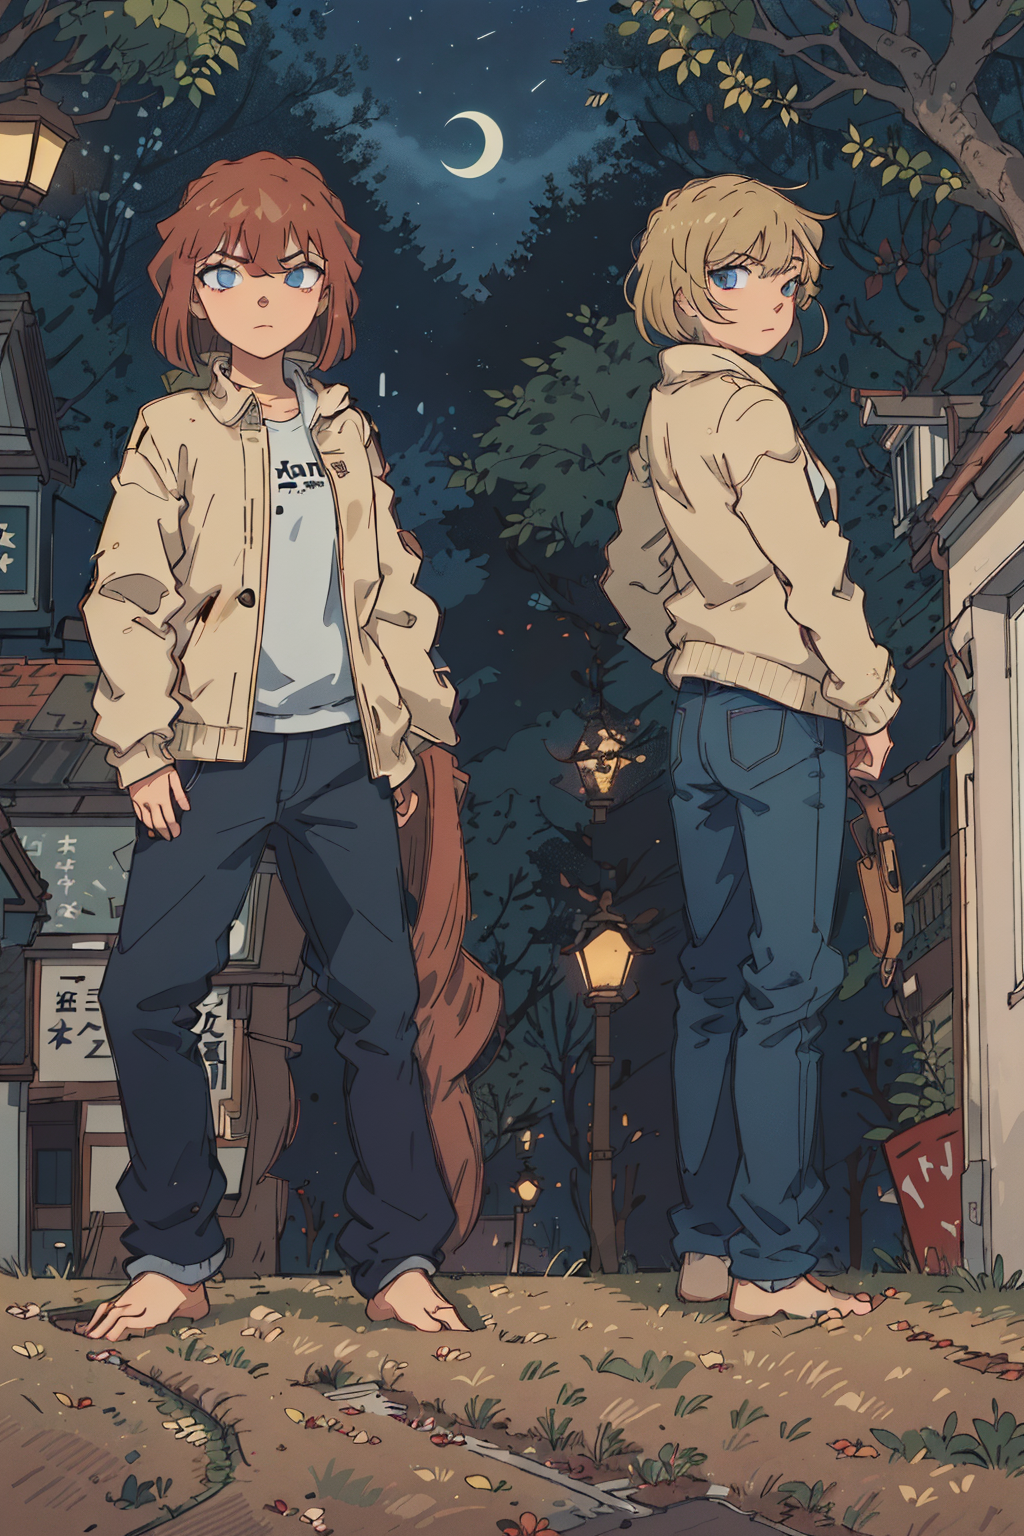

In [26]:
result_control_latent_couple.get_image()